# Load Package

In [3]:

import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from random import randint

import numpy as np
from keras.models import Sequential
from keras.layers import Dense,  Masking, Conv1D, MaxPooling1D
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras_preprocessing import sequence
from sklearn.model_selection import train_test_split
import os


Using TensorFlow backend.


In [0]:
pip install ndjson

In [0]:
!mkdir data

# Functions

In [0]:
def parse_line(data):
  """Parse an ndjson line and return ink (as np array) and classname."""
  # sample = ndjson.loads(ndjson_line)
  sample = data
  class_name = sample["countrycode"]
  inkarray = sample["drawing"]
  stroke_lengths = [len(stroke[0]) for stroke in inkarray]
  total_points = sum(stroke_lengths)
  np_ink = np.zeros((total_points, 3), dtype=np.float32)
  current_t = 0
  for stroke in inkarray:
    for i in [0, 1]:
      np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i]
    current_t += len(stroke[0])
    np_ink[current_t - 1, 2] = 1  # stroke_end
  # # Preprocessing.
  # # 1. Size normalization.
  # lower = np.min(np_ink[:, 0:2], axis=0)
  # upper = np.max(np_ink[:, 0:2], axis=0)
  # scale = upper - lower
  # scale[scale == 0] = 1
  # np_ink[:, 0:2] = (np_ink[:, 0:2] - lower) / scale
  # # 2. Compute deltas.
  # np_ink[1:, 0:2] -= np_ink[0:-1, 0:2]
  # np_ink = np_ink[1:, :]
  return np_ink, class_name

def generator_data(train_x,train_y,batch_size):   
    count = 0
    index = -1
    max_draw = len(train_x)
    x = []
    y = []
    while True:
      while count < batch_size:
          index += 1
          # print(index)
          y += [to_categorical(train_y[index], num_classes=class_num)]
          x += [sequence.pad_sequences([train_x[index]], value=-1, \
                                       maxlen=max_len, padding='post')[0]]
          if index >= max_draw-1:
              index = -1
          count += 1

      yield[np.array(x),np.array(y,)]
      x = []
      y = []
      count = 0

# CNN+LSTM

## Load Data

In [0]:
classes = ['eye']#,'mouth','nose','ear','circle']

In [0]:
import urllib.request
import ndjson
def download():
  
  # base = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
  # base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/simplified/'
  
  for c in classes:
    # path = base+c+'.bin'
    path = base+c+'.ndjson'
    print(path)
    # urllib.request.urlretrieve(path, 'data/'+c+'.bin')
    urllib.request.urlretrieve(path, 'data/'+c+'.ndjson')
download()

https://storage.googleapis.com/quickdraw_dataset/full/simplified/eye.ndjson


In [0]:
all_files = glob.glob(os.path.join('data', '*.ndjson'))
with open(all_files[0]) as f:
    data = ndjson.load(f)

## Data Pre-processing

In [0]:
# Add stroke information to original vector drawings
parse_line(data[6])[0]

array([[  1.,  36.,   0.],
       [ 29.,  30.,   0.],
       [ 67.,   5.,   0.],
       [ 89.,   5.,   0.],
       [ 98.,   8.,   0.],
       [108.,  17.,   0.],
       [123.,   8.,   0.],
       [143.,   2.,   0.],
       [164.,   0.,   0.],
       [181.,   5.,   0.],
       [211.,  23.,   0.],
       [243.,  35.,   0.],
       [231.,  37.,   1.],
       [  0.,  40.,   0.],
       [  4.,  55.,   0.],
       [ 22.,  74.,   0.],
       [ 41.,  89.,   0.],
       [ 65.,  95.,   0.],
       [117.,  96.,   0.],
       [161.,  95.,   0.],
       [210.,  79.,   0.],
       [249.,  57.,   0.],
       [254.,  49.,   0.],
       [255.,  42.,   0.],
       [252.,  41.,   1.],
       [  1.,  46.,   0.],
       [240.,  42.,   1.]], dtype=float32)

In [7]:
a.shape

(27, 3)

In [6]:
# pad sequence with -1 to make the input for each image has the same length
np.array(sequence.pad_sequences([parse_line(data[6])[0]], value=-1, \
                                       maxlen=400, padding='post')[0])

array([[ 1, 36,  0],
       [29, 30,  0],
       [67,  5,  0],
       ...,
       [-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1]], dtype=int32)

In [0]:
# only keep the data we want
countries = ['AU','KR','SA','BR']
index = 0
while index < len(data):
  if data[index]['recognized']== 0 or data[index]['countrycode'] not in countries:
    data.pop(index)
  else:
    index += 1

In [0]:
# change data format to feed into RNN
np_ink = []
countrycode = []
for i in data:
  result = parse_line(i)
  np_ink += [result[0]]
  countrycode += [result[1]]
countries_mapping = {'AU': 0,'BR': 1,'KR': 2,'SA': 3}
countrycode = [countries_mapping[x] for x in countrycode]


In [0]:
# the data are roughly balanced
from collections import Counter
result = Counter(countrycode)
print(result)

Counter({0: 2744, 1: 2177, 2: 1891, 3: 1600})


## Build Model

In [0]:
max_len = max([len(draw) for draw in np_ink]) # 286
class_num = len(countries)

In [0]:
batch_size = 64
train_x = np_ink[:7000]
train_y = countrycode[:7000]
test_x = np_ink[7000:]
test_y = countrycode[7000:]


generator = generator_data(train_x,train_y,batch_size)
generator_dev = generator_data(train_x,train_y,batch_size)
steps = len(train_x) // batch_size
steps_dev = len(test_x) // batch_size


In [0]:
model = Sequential()

#conv+lstm
model.add(Conv1D(filters=128, kernel_size=3, activation='relu',padding="same"\
                 ,input_shape=(None,3)))
model.add(MaxPooling1D(pool_size=2,strides=2))
model.add(Masking(mask_value=-1, input_shape=(max_len//2, 3)))
model.add(LSTM(units=256, input_shape=(max_len//2, 3)))
# model.add(Dropout(0.2))
model.add(Dense(class_num, activation='softmax'))
adam = Adam(lr=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 128)         1280      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
masking_6 (Masking)          (None, None, 128)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 1028      
Total params: 396,548
Trainable params: 396,548
Non-trainable params: 0
_________________________________________________________________


Here is the structure of RNN

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


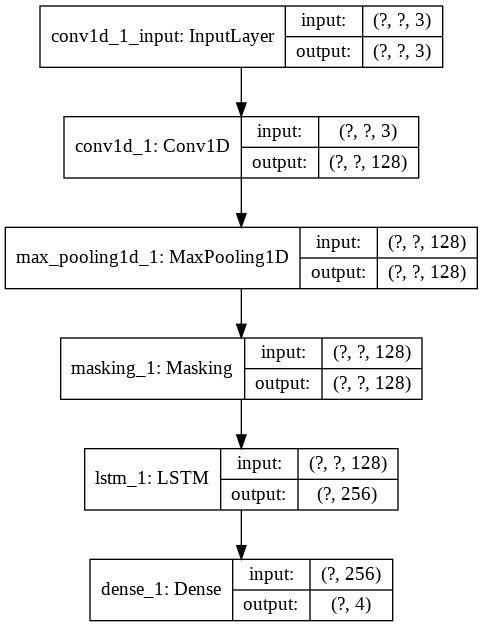

In [0]:
from keras.utils import plot_model
tf.keras.utils.plot_model(model, to_file='gdrive/My Drive/rnn_country_classfication_model.png',\
                          show_shapes=True) 

## Train the Model

In [0]:
model.fit_generator(generator=generator, steps_per_epoch=steps, \
                    epochs=10,verbose=1, validation_data = generator_dev,validation_steps = steps_dev)  



Epoch 1/10
109/109 [==============================] - 31s 287ms/step - loss: 1.3724 - acc: 0.3247 - val_loss: 1.3670 - val_acc: 0.3246
Epoch 2/10
109/109 [==============================] - 29s 269ms/step - loss: 1.3684 - acc: 0.3253 - val_loss: 1.3711 - val_acc: 0.3161
Epoch 3/10
109/109 [==============================] - 29s 267ms/step - loss: 1.3680 - acc: 0.3251 - val_loss: 1.3614 - val_acc: 0.3324
Epoch 4/10
109/109 [==============================] - 30s 271ms/step - loss: 1.3678 - acc: 0.3253 - val_loss: 1.3685 - val_acc: 0.3253
Epoch 5/10
109/109 [==============================] - 29s 264ms/step - loss: 1.3676 - acc: 0.3254 - val_loss: 1.3654 - val_acc: 0.3295
Epoch 6/10
109/109 [==============================] - 28s 259ms/step - loss: 1.3673 - acc: 0.3254 - val_loss: 1.3663 - val_acc: 0.3224
Epoch 7/10
109/109 [==============================] - 29s 264ms/step - loss: 1.3677 - acc: 0.3251 - val_loss: 1.3838 - val_acc: 0.2955
Epoch 8/10
109/109 [==============================] - 2

# Model Comparision

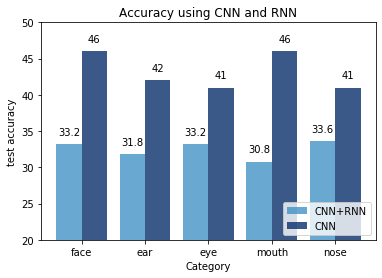

In [0]:
x_rnn = ['face','ear','eye','mouth','nose']
y_rnn = [33.2,31.8,33.2,30.8,33.6]
y_cnn = [46,42,41,46,41]

x = range(len(x_rnn))

rects1 = plt.bar(x,y_rnn, color = "#4292c6", width=0.4, alpha=0.8, label="CNN+RNN")
rects2 = plt.bar([i + 0.4 for i in x],y_cnn, color = "#08306b", width=0.4, alpha=0.8, label="CNN")
plt.xticks([i + 0.2 for i in x],x_rnn)
plt.ylim(20, 50)     
plt.ylabel("test accuracy")


plt.xlabel("Category")
plt.title("Accuracy using CNN and RNN")
plt.legend(loc='lower right',ncol=1)    
  

for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")
for rect in rects2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")
plt.show()
